In [2]:
import pandas as pd
from Levenshtein import distance

In [4]:
# Load baseline and human-written summaries
gold = pd.read_csv("../eval/gold_lftk.csv", index_col=0)
gen = pd.read_csv("../eval/gen_lftk.csv", index_col=0)

In [39]:
gen.loc[1211].summary_generated

'Senior Nutrition Act of 2002 - Amends the Agriculture and Consumer Protection Act of 1973 to make elderly persons eligible for the commodity supplemental food program if they are at least 60 years old and have a household income less than or equal to 185 percent of the most recent Federal Poverty Income Guidelines. Authorizes appropriations for the program.'

In [41]:
gold.loc[1211].summary

'Senior Nutrition Act of 2002 - Amends the Agriculture and Consumer Protection Act of 1973 to make a person who is at least 60 years old eligible for the commodity supplemental food program (program) if such person: (1) is eligible for the food stamp program; or (2) has a household income that is not more than 185 percent of the federal poverty income guidelines.Authorizes permanent program appropriations.'

## How many summaries are fewer than 100 words?

Any summary with fewer than 100 words has an invalid Coleman-Liau index value...

In [18]:
len(gold.loc[gold.t_word < 100])

718

In [19]:
len(gen.loc[gen.t_word < 100])

956

So what is the true number of valid gold-generated pairs that we can compare Coleman-Liau scores for?

In [48]:
gen_valid = gen.loc[gen.t_word > 100]
gold_valid = gold.loc[gold.t_word > 100]
len(gen_valid.index.intersection(gold_valid.index))

2007

## How many summaries are fewer than 30 sentences?
Any summary with fewer than 30 sentences has an invalid SMOG index value...

In [52]:
len(gold.loc[gold.t_sent < 30])

3269

In [53]:
len(gen.loc[gen.t_sent < 30])

3269

## How many gold summaries are only 1 sentence?

We can move this $k$ value to any arbitrary number, but 1 is the lower bound....

In [51]:
len(gen.loc[gen.t_sent == 1])

654

## How many generated summaries are truncated?

Let's try to answer this by counting how many generated summaries end with characters that are not alphabetical numbers.

In [13]:
last_char = dict(gen.summary_generated.str[-1].value_counts())

In [15]:
trunc = 0
for k in last_char:
    if k.isalpha():
        trunc += last_char[k]
trunc

649

## How many generated summaries are (close to) verbatim copies?
First we can try to calculate this using Levenshtein edit distance (AKA number of character-level edits to get from string A to B)

In [5]:
result = []
for gold_summary, gen_summary in zip(gold.summary.tolist(), gen.summary_generated.tolist()):
    curr = distance(gen_summary, gold_summary)
    result.append(curr)
gen["levenshtein"] = result

<Axes: xlabel='Levenshtein distance between generated and gold summaries', ylabel='Frequency'>

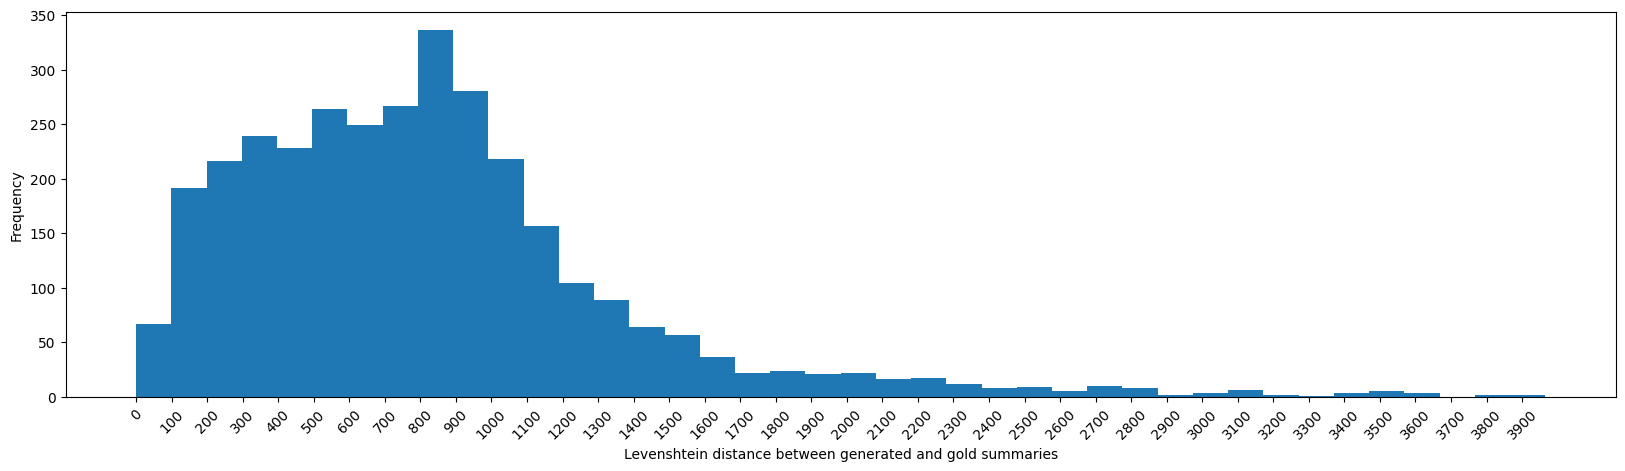

In [23]:
gen.levenshtein.plot.hist(bins=40, xticks=range(0, 4000, 100), rot=45, figsize=(20,5), xlabel='Levenshtein distance between generated and gold summaries')

It looks like we actually only see a small number of generated summaries with levenshtein edit distance under 100. Generated summaries with distance under 200 is about ~8% of the total generated dataset

Let's now try to answer this question by discovering outliers in ROUGE scores...

In [3]:
rouge = pd.read_csv("../eval/rouge_scores.txt", sep="\t", nrows=3269)

In [29]:
def lazy_parse(text):
    return text.split(",")[0].replace(")", "")

def parse_scores(row, score_type):
    # Example: Score(precision=0.8736842105263158, recall=0.30970149253731344, fmeasure=0.4573002754820937)
    parsed = row[score_type].split("=")
    row[f"{score_type}_precision"] = float(lazy_parse(parsed[1]))
    row[f"{score_type}_recall"] = float(lazy_parse(parsed[2]))
    row[f"{score_type}_fmeasure"] = float(lazy_parse(parsed[3]))
    return row

# Store results
result = []

# Lazy implementation - iterate over rows
for i, row in rouge.iterrows():
    curr = row
    for c in rouge.columns:
        curr = parse_scores(curr, c)
    result.append(curr)

# Cast as dataframe and drop old columns
df = pd.DataFrame(result)
df = df.drop(columns=rouge.columns)

rouge1              Score(precision=0.7163461538461539, recall=0.4...
rouge2              Score(precision=0.42995169082125606, recall=0....
rougeL              Score(precision=0.46634615384615385, recall=0....
rouge1_precision                                             0.716346
rouge1_recall                                                0.476038
rouge1_fmeasure                                              0.571977
rouge2_precision                                             0.429952
rouge2_recall                                                0.285256
rouge2_fmeasure                                              0.342967
rougeL_precision                                             0.466346
rougeL_recall                                                0.309904
rougeL_fmeasure                                              0.372361
Name: 0, dtype: object

<Axes: ylabel='Frequency'>

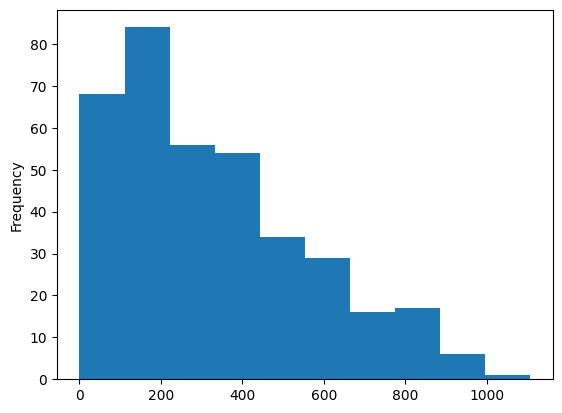

In [47]:
# df.loc[(df == 1).any(axis=1)]
df.loc[df.rouge1_fmeasure >= 0.75].join(gen.levenshtein)["levenshtein"].plot.hist()

## What functions do different bills serve?

Let's try to approximate the intent of a bill with keywords like "amend" and "cited as"

In [49]:
from datasets import load_dataset

In [50]:
ds = load_dataset("FiscalNote/billsum")["test"].to_pandas()

In [84]:
ds["keyphrase"] = ds.text.str.split("\n")[1][0]

In [90]:
amended = ds.loc[ds.keyphrase.str.contains("amended")]
cited = ds.loc[ds.keyphrase.str.contains("Act may be cited")]

In [92]:
ds.keyphrase.

0       That this Act may be cited as the ``Federal Fo...
1       That this Act may be cited as the ``Federal Fo...
2       That this Act may be cited as the ``Federal Fo...
3       That this Act may be cited as the ``Federal Fo...
4       That this Act may be cited as the ``Federal Fo...
                              ...                        
3264    That this Act may be cited as the ``Federal Fo...
3265    That this Act may be cited as the ``Federal Fo...
3266    That this Act may be cited as the ``Federal Fo...
3267    That this Act may be cited as the ``Federal Fo...
3268    That this Act may be cited as the ``Federal Fo...
Name: keyphrase, Length: 3269, dtype: object